In [1]:
import pandas as pd
df_raw = pd.read_csv('RecipeDB_ingredient_phrase.csv')
print(df_raw.head())

   recipe_no          ingredient_Phrase  ingredient      state quantity  unit  \
0       2610               3 cups water       water        NaN        3  cups   
1       2610          1 cup red lentils  red lentil        NaN        1   cup   
2       2610  1 roma tomato , quartered  rom tomato  quartered        1   NaN   
3       2610       1 carrot , quartered      carrot  quartered        1   NaN   
4       2610  1 small onion , quartered       onion  quartered        1   NaN   

  temp   df   size  ing_id  ndb_id M_or_A  
0  NaN  NaN    NaN       3   14555      M  
1  NaN  NaN    NaN     452   16144      A  
2  NaN  NaN    NaN     180   93600      A  
3  NaN  NaN    NaN      21   11124      M  
4  NaN  NaN  small       1   11282      M  


In [2]:
df = df_raw[['recipe_no', 'ingredient']]
print(df.head())

   recipe_no  ingredient
0       2610       water
1       2610  red lentil
2       2610  rom tomato
3       2610      carrot
4       2610       onion


In [3]:
df_grouped = df.groupby('recipe_no')['ingredient'].apply(list).reset_index()
df_grouped.columns = ['id', 'ingredients']
print(df_grouped.head())

     id                                        ingredients
0  2610  [water, red lentil, rom tomato, carrot, onion,...
1  2611  [vegetable oil, onion, tomato paste, garlic, c...
2  2612  [olive oil, onion, lamb shoulder, salt black p...
3  2613  [onion, olive oil, garbanzo bean, cream, cornm...
4  2614  [hazelnut, sesame seed, coriander seed, cumin ...


In [4]:
df_grouped.to_csv('transformed_recipes.csv', index=False)

In [4]:
import ast
df = pd.read_csv('transformed_recipes.csv')
df['ingredients'] = df['ingredients'].apply(ast.literal_eval)
print("Shape:", df.shape)
print(df.head())

Shape: (118083, 2)
     id                                        ingredients
0  2610  [water, red lentil, rom tomato, carrot, onion,...
1  2611  [vegetable oil, onion, tomato paste, garlic, c...
2  2612  [olive oil, onion, lamb shoulder, salt black p...
3  2613  [onion, olive oil, garbanzo bean, cream, cornm...
4  2614  [hazelnut, sesame seed, coriander seed, cumin ...


In [5]:
all_ingredients = [ing for sublist in df["ingredients"] for ing in sublist]
ingredient_counts = pd.Series(all_ingredients).value_counts()
print("Total unique ingredients:", ingredient_counts.index.nunique())
print("Top 20 most common ingredients:")
print(ingredient_counts.head(20))

Total unique ingredients: 20280
Top 20 most common ingredients:
salt             45206
onion            34548
butter           27013
garlic clove     24893
water            24773
olive oil        22391
egg              21861
sugar            20271
tomato           16625
black pepper     15973
garlic           15436
milk             14585
pepper           12304
salt pepper      10387
flour             9837
parsley           9718
cinnamon          9624
lemon juice       9509
carrot            9087
purpose flour     9023
Name: count, dtype: int64


In [6]:
df["num_ingredients"] = df["ingredients"].apply(len)
print("Recipe with fewest ingredients:")
print(df.loc[df["num_ingredients"].idxmin()])
print("Recipe with most ingredients:")
print(df.loc[df["num_ingredients"].idxmax()])

Recipe with fewest ingredients:
id                                        2832
ingredients        [water, gari cassava flour]
num_ingredients                              2
Name: 222, dtype: object
Recipe with most ingredients:
id                                                             53370
ingredients        [brown rice, green onion, oil, soy sauce, salt...
num_ingredients                                                   38
Name: 22329, dtype: object


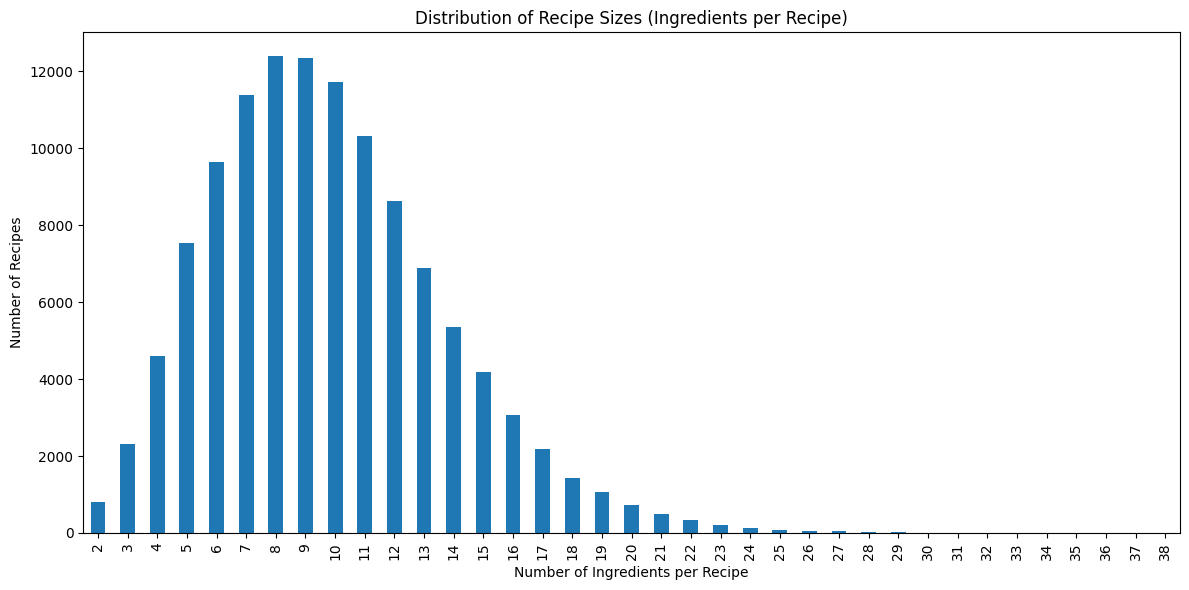

In [8]:
import matplotlib.pyplot as plt
df["num_ingredients"] = df["ingredients"].apply(len)
plt.figure(figsize=(12,6))
df["num_ingredients"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Number of Ingredients per Recipe")
plt.ylabel("Number of Recipes")
plt.title("Distribution of Recipe Sizes (Ingredients per Recipe)")
plt.tight_layout()
plt.show()

In [9]:
avg_recipe_size = df["num_ingredients"].mean()
unique_ing = ingredient_counts.index.nunique()
print(f"\nOn average, each recipe uses {avg_recipe_size:.2f} out of {unique_ing} unique ingredients "
      f"({(avg_recipe_size/unique_ing)*100:.4f}% density).")


On average, each recipe uses 9.78 out of 20280 unique ingredients (0.0482% density).


In [10]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

recipes = df["ingredients"].apply(lambda x: [i.lower() for i in x]).tolist()

te = TransactionEncoder()
te_ary = te.fit(recipes).transform(recipes)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)

total_recipes = len(df_encoded)
frequent_itemsets['count'] = frequent_itemsets['support'] * total_recipes

def show_itemsets_by_size(size, n=5):
    subset = frequent_itemsets[frequent_itemsets['length'] == size]
    print(f"\nTop {n} frequent itemsets of size {size}:")
    print(subset[['itemsets', 'support', 'count']].head(n))

show_itemsets_by_size(1, 5)
show_itemsets_by_size(2, 5)
show_itemsets_by_size(3, 5)
show_itemsets_by_size(4, 5)

print("\nNumber of frequent itemsets by length:")
summary = frequent_itemsets['length'].value_counts().sort_index()
for length, count in summary.items():
    print(f"Length {length}: {int(count)} itemsets")



Top 5 frequent itemsets of size 1:
     itemsets   support   count
0  (allspice)  0.015176  1792.0
1    (almond)  0.028014  3308.0
2     (apple)  0.012356  1459.0
3   (avocado)  0.018639  2201.0
4     (bacon)  0.027591  3258.0

Top 5 frequent itemsets of size 2:
             itemsets   support   count
164  (almond, butter)  0.011848  1399.0
165    (almond, salt)  0.010171  1201.0
166   (sugar, almond)  0.010755  1270.0
167    (bacon, onion)  0.014431  1704.0
168     (bacon, salt)  0.010315  1218.0

Top 5 frequent itemsets of size 3:
                                   itemsets   support   count
612            (baking powder, egg, butter)  0.019300  2279.0
613           (butter, baking powder, milk)  0.010662  1259.0
614  (butter, baking powder, purpose flour)  0.011280  1332.0
615           (baking powder, salt, butter)  0.016285  1923.0
616          (sugar, baking powder, butter)  0.014710  1737.0

Top 5 frequent itemsets of size 4:
                                          itemsets  

In [11]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(by="lift", ascending=False)
print("\nAssociation Rules:")
rules = rules.reset_index(drop=True)
print(rules[['antecedents', 'consequents', 'support', 'confidence']].head(20))


Association Rules:
                antecedents              consequents   support  confidence
0               (soy sauce)             (sesame oil)  0.016141    0.246668
1              (sesame oil)              (soy sauce)  0.016141    0.690330
2           (baking powder)     (egg, purpose flour)  0.014016    0.319436
3      (egg, purpose flour)          (baking powder)  0.014016    0.366150
4                (cinnamon)                  (clove)  0.019139    0.234830
5                   (clove)               (cinnamon)  0.019139    0.673421
6   (baking powder, butter)             (sugar, egg)  0.011678    0.464466
7              (sugar, egg)  (baking powder, butter)  0.011678    0.203542
8           (baking powder)       (sugar, salt, egg)  0.011458    0.261146
9        (sugar, salt, egg)          (baking powder)  0.011458    0.355025
10                (vanilla)             (sugar, egg)  0.010848    0.461788
11             (sugar, egg)                (vanilla)  0.010848    0.189077
12   

In [12]:
chicken_recipes = df[df["ingredients"].apply(lambda x: "chicken" in [i.lower() for i in x])]
chicken_ingredients = [ing.lower() for sublist in chicken_recipes["ingredients"] for ing in sublist]
chicken_counts = pd.Series(chicken_ingredients).value_counts().drop("chicken")
print("\nTop 20 co-occurring ingredients with chicken:")
print(chicken_counts.head(20))


Top 20 co-occurring ingredients with chicken:
onion            1630
salt             1520
garlic clove     1059
water             760
olive oil         720
tomato            680
garlic            676
butter            632
black pepper      623
ginger            506
chicken broth     505
pepper            473
cumin             450
cilantro          440
carrot            425
salt pepper       393
oil               391
egg               385
soy sauce         379
vegetable oil     379
Name: count, dtype: int64


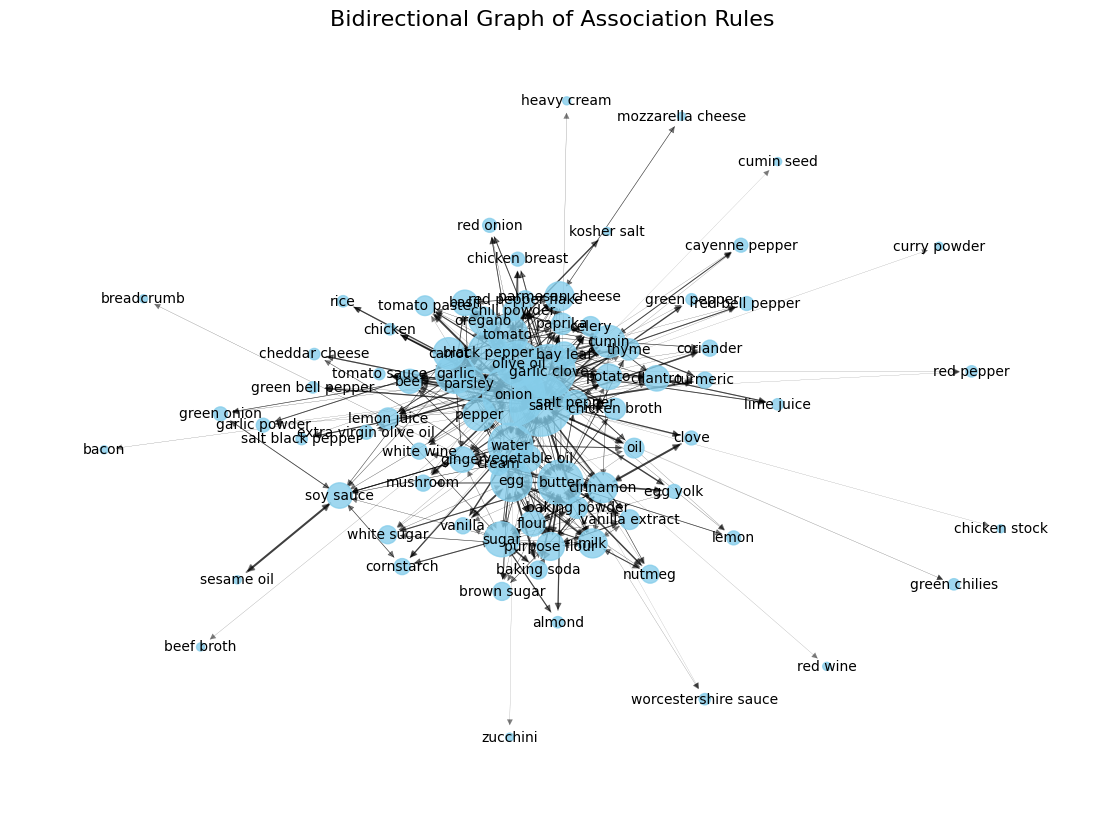

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(
                antecedent, 
                consequent, 
                weight=row['confidence'], 
                support=row['support'],
                lift=row['lift']
            )
            G.add_edge(
                consequent, 
                antecedent, 
                weight=row['confidence'], 
                support=row['support'],
                lift=row['lift']
            )

plt.figure(figsize=(14, 10))

pos = nx.spring_layout(G, k=0.3, iterations=50)

node_sizes = [2000 * (G.degree(node)/max(dict(G.degree()).values())) for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.8)

# Draw edges (width = confidence)
edge_weights = [d['weight']*2 for (_, _, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.5, arrows=True)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

plt.title("Bidirectional Graph of Association Rules", fontsize=16)
plt.axis("off")
plt.show()


In [ ]:
import networkx as nx

nx.write_graphml(G, "association_rules.graphml")


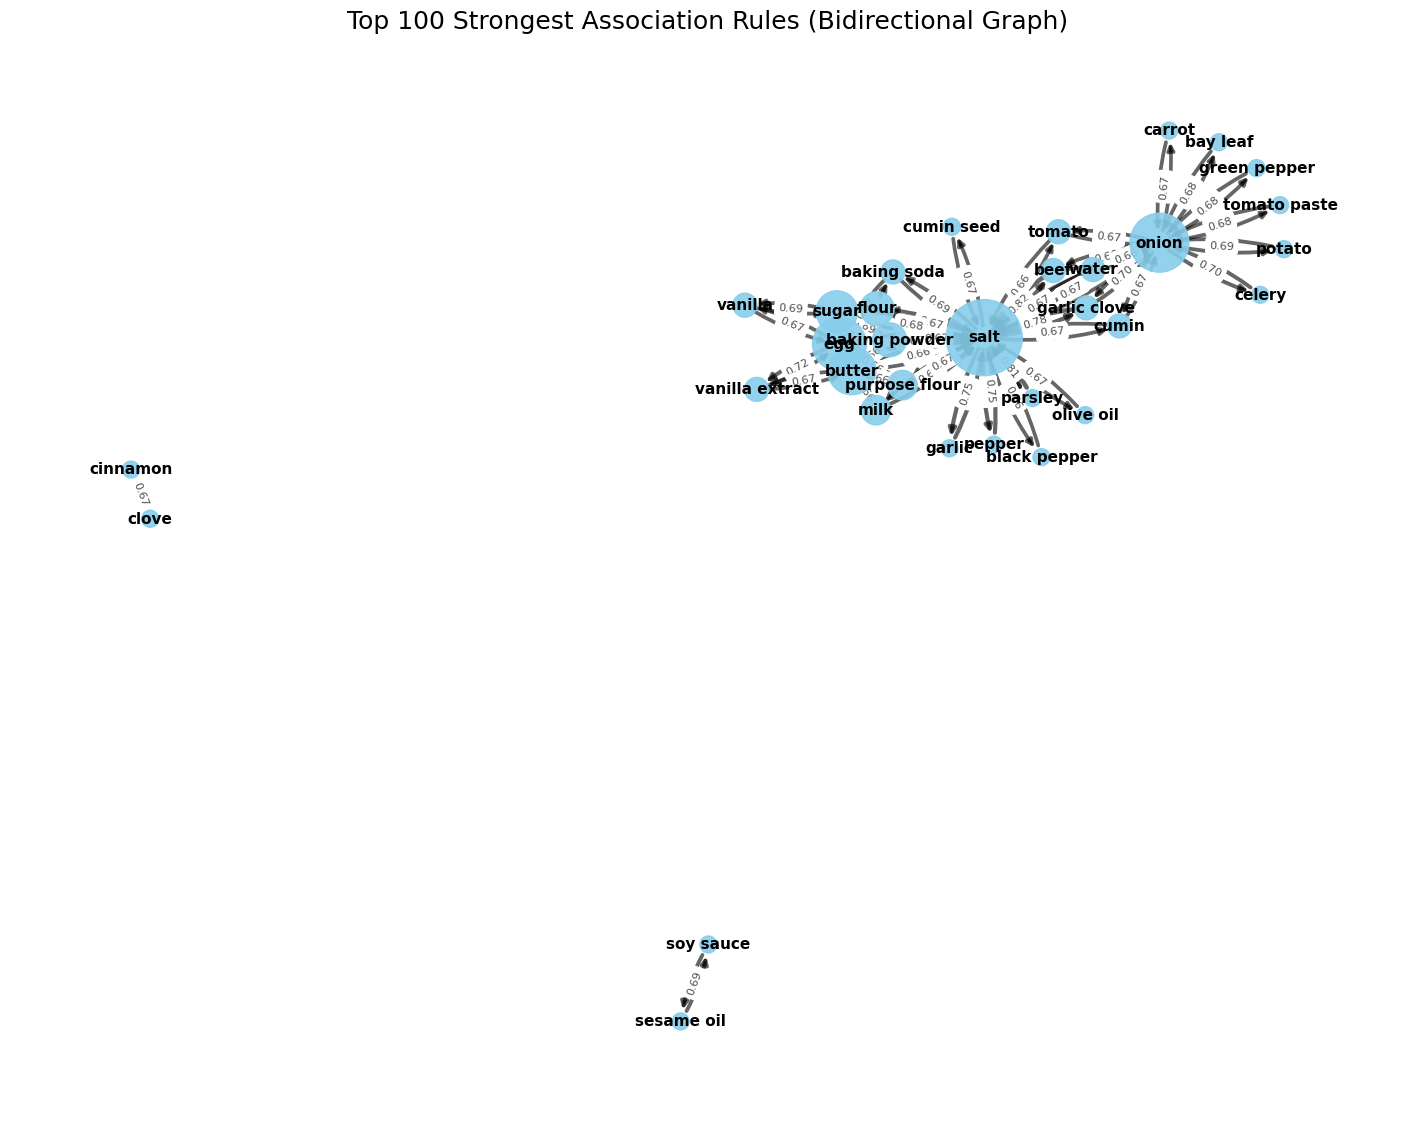

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

top_rules = rules.sort_values(by="confidence", ascending=False).head(100)

G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(
                antecedent, consequent,
                weight=row['confidence'],
                support=row['support'],
                lift=row['lift']
            )
            G.add_edge(
                consequent, antecedent,
                weight=row['confidence'],
                support=row['support'],
                lift=row['lift']
            )

plt.figure(figsize=(18, 14))
pos = nx.spring_layout(G, k=0.7, iterations=200)

node_sizes = [3000 * (G.degree(node)/max(dict(G.degree()).values())) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.9)

edge_weights = [d['weight']*4 for (_, _, d) in G.edges(data=True)]
nx.draw_networkx_edges(
    G, pos, width=edge_weights, alpha=0.6, arrows=True, connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, alpha=0.7)

plt.title("Top 100 Strongest Association Rules (Bidirectional Graph)", fontsize=18)
plt.axis("off")
plt.show()

nx.write_graphml(G, "association_rules_top100.graphml")


In [7]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

general_df = pd.read_csv("RecipeDB_general.csv")

query = "pizza"

pizza_recipes = general_df[general_df["Recipe_title"].str.lower().str.contains(query)]
pizza_ids = pizza_recipes["Recipe_id"].unique()

print(f"Found {len(pizza_ids)} recipes containing '{query}' in their title.")

filtered_recipes = df[df["id"].isin(pizza_ids)]["ingredients"].apply(lambda x: [i.lower() for i in x]).tolist()

te = TransactionEncoder()
te_ary = te.fit(filtered_recipes).transform(filtered_recipes)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)
frequent_itemsets['count'] = frequent_itemsets['support'] * len(df_encoded)
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(list)

# Summary
print("\nNumber of frequent itemsets by length:")
summary = frequent_itemsets['length'].value_counts().sort_index()
for length, count in summary.items():
    print(f"Length {length}: {int(count)} itemsets")

# Show top itemsets
for s in range(1, 4):
    subset = frequent_itemsets[frequent_itemsets['length'] == s]
    print(f"\nTop frequent itemsets of size {s}:")
    print(subset[['itemsets', 'support', 'count']].head(5))

# Association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print("\nTop Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence']].head(10))


C:\Users\dhawal bansal\AppData\Local\Temp\ipykernel_21204\407505421.py:5: DtypeWarning: Columns (2,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  general_df = pd.read_csv("RecipeDB_general.csv")


Found 1261 recipes containing 'pizza' in their title.

Number of frequent itemsets by length:
Length 1: 145 itemsets
Length 2: 694 itemsets
Length 3: 800 itemsets
Length 4: 416 itemsets
Length 5: 72 itemsets
Length 6: 2 itemsets

Top frequent itemsets of size 1:
            itemsets   support  count
0     [active yeast]  0.083267  105.0
1  [artichoke heart]  0.039651   50.0
2          [avocado]  0.011895   15.0
3            [bacon]  0.022205   28.0
4    [baking powder]  0.016653   21.0

Top frequent itemsets of size 2:
                                   itemsets   support  count
145                   [active yeast, basil]  0.010309   13.0
146            [active yeast, black pepper]  0.010309   13.0
147             [active yeast, bread flour]  0.020619   26.0
148  [extra virgin olive oil, active yeast]  0.013481   17.0
149                   [flour, active yeast]  0.011895   15.0

Top frequent itemsets of size 3:
                                         itemsets   support  count
839     

In [8]:
all_ingredients = [ing for recipe in filtered_recipes for ing in recipe]

unique_ingredients = set(all_ingredients)

print(f"\nTotal unique ingredients in pizza recipes: {len(unique_ingredients)}")
print(f"Sample ingredients: {list(unique_ingredients)[:20]}")



Total unique ingredients in pizza recipes: 1240
Sample ingredients: ['barley malt', 'raisin', 'head lettuce', 'greek olive', 'cheese spread', 'el paso taco seasoning mix', 'portobello mushroom', 'rotini pasta', 'sea salt black pepper', 'steak', 'ricotta', 'tomato basil garlic seasoning', 'grape', 'pillsbury biscuit', 'spaghetti', 'tabasco sauce', 'yellow pepper', 'arugula', 'crust pizza dough pillsbury', 'red chili powder']


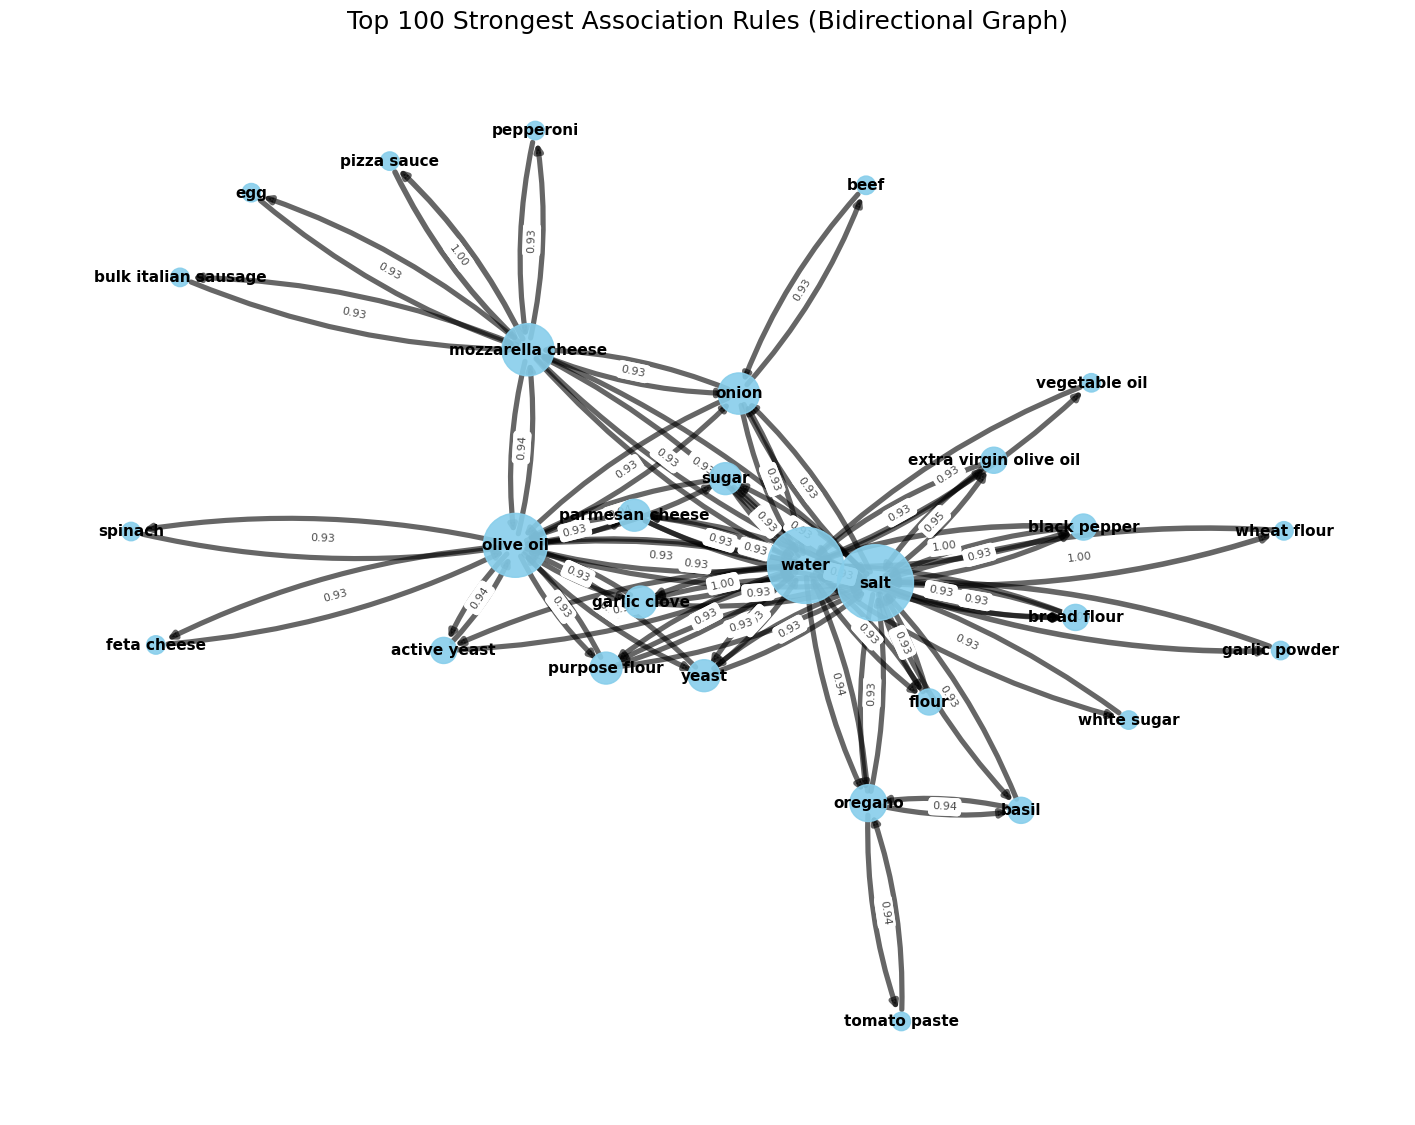

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

top_rules = rules.sort_values(by="confidence", ascending=False).head(100)

G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(
                antecedent, consequent,
                weight=row['confidence'],
                support=row['support'],
                lift=row['lift']
            )
            G.add_edge(
                consequent, antecedent,
                weight=row['confidence'],
                support=row['support'],
                lift=row['lift']
            )

plt.figure(figsize=(18, 14))
pos = nx.spring_layout(G, k=0.7, iterations=200)

node_sizes = [3000 * (G.degree(node)/max(dict(G.degree()).values())) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.9)

edge_weights = [d['weight']*4 for (_, _, d) in G.edges(data=True)]
nx.draw_networkx_edges(
    G, pos, width=edge_weights, alpha=0.6, arrows=True, connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, alpha=0.7)

plt.title("Top 100 Strongest Association Rules (Bidirectional Graph)", fontsize=18)
plt.axis("off")
plt.show()

nx.write_graphml(G, "association_rules_pizza_top100.graphml")


In [11]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Load general recipe dataset
general_df = pd.read_csv("RecipeDB_general.csv")

query = "biryani"

biryani_recipes = general_df[general_df["Recipe_title"].str.lower().str.contains(query)]
biryani_ids = biryani_recipes["Recipe_id"].unique()

print(f"Found {len(biryani_ids)} recipes containing '{query}' in their title.")

filtered_recipes = df[df["id"].isin(biryani_ids)]["ingredients"].apply(lambda x: [i.lower() for i in x]).tolist()

all_ingredients = [ing for recipe in filtered_recipes for ing in recipe]
unique_ingredients = set(all_ingredients)
print(f"\nTotal unique ingredients in biryani recipes: {len(unique_ingredients)}")
print(f"Sample ingredients: {list(unique_ingredients)[:20]}")

te = TransactionEncoder()
te_ary = te.fit(filtered_recipes).transform(filtered_recipes)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)
frequent_itemsets['count'] = frequent_itemsets['support'] * len(df_encoded)
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(list)

print("\nNumber of frequent itemsets by length:")
summary = frequent_itemsets['length'].value_counts().sort_index()
for length, count in summary.items():
    print(f"Length {length}: {int(count)} itemsets")

for s in range(1, 7):
    subset = frequent_itemsets[frequent_itemsets['length'] == s]
    print(f"\nTop frequent itemsets of size {s}:")
    print(subset[['itemsets', 'support', 'count']].head(5))

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print("\nTop Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence']].head(10))


C:\Users\dhawal bansal\AppData\Local\Temp\ipykernel_21204\4214219525.py:6: DtypeWarning: Columns (2,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  general_df = pd.read_csv("RecipeDB_general.csv")


Found 91 recipes containing 'biryani' in their title.

Total unique ingredients in biryani recipes: 265
Sample ingredients: ['golden raisin', 'raisin', 'cumin coriander powder', 'wheat flour', 'clove', 'hot water', 'cumin powder', 'flat leaf parsley', 'garlic paste', 'cauliflower', 'garlic powder', 'fennel seed', 'lamb', 'dhaniya powder', 'chicken breast', 'green chile pepper lengthwise', 'cold water', 'garlic', 'yellow chili powder', 'soymilk']

Number of frequent itemsets by length:
Length 1: 52 itemsets
Length 2: 291 itemsets
Length 3: 521 itemsets
Length 4: 430 itemsets
Length 5: 202 itemsets
Length 6: 55 itemsets
Length 7: 7 itemsets

Top frequent itemsets of size 1:
               itemsets   support  count
0        [basmati rice]  0.637363   58.0
1            [bay leaf]  0.373626   34.0
2  [black cardamom pod]  0.142857   13.0
3        [black pepper]  0.175824   16.0
4    [black peppercorn]  0.142857   13.0

Top frequent itemsets of size 2:
                        itemsets   supp

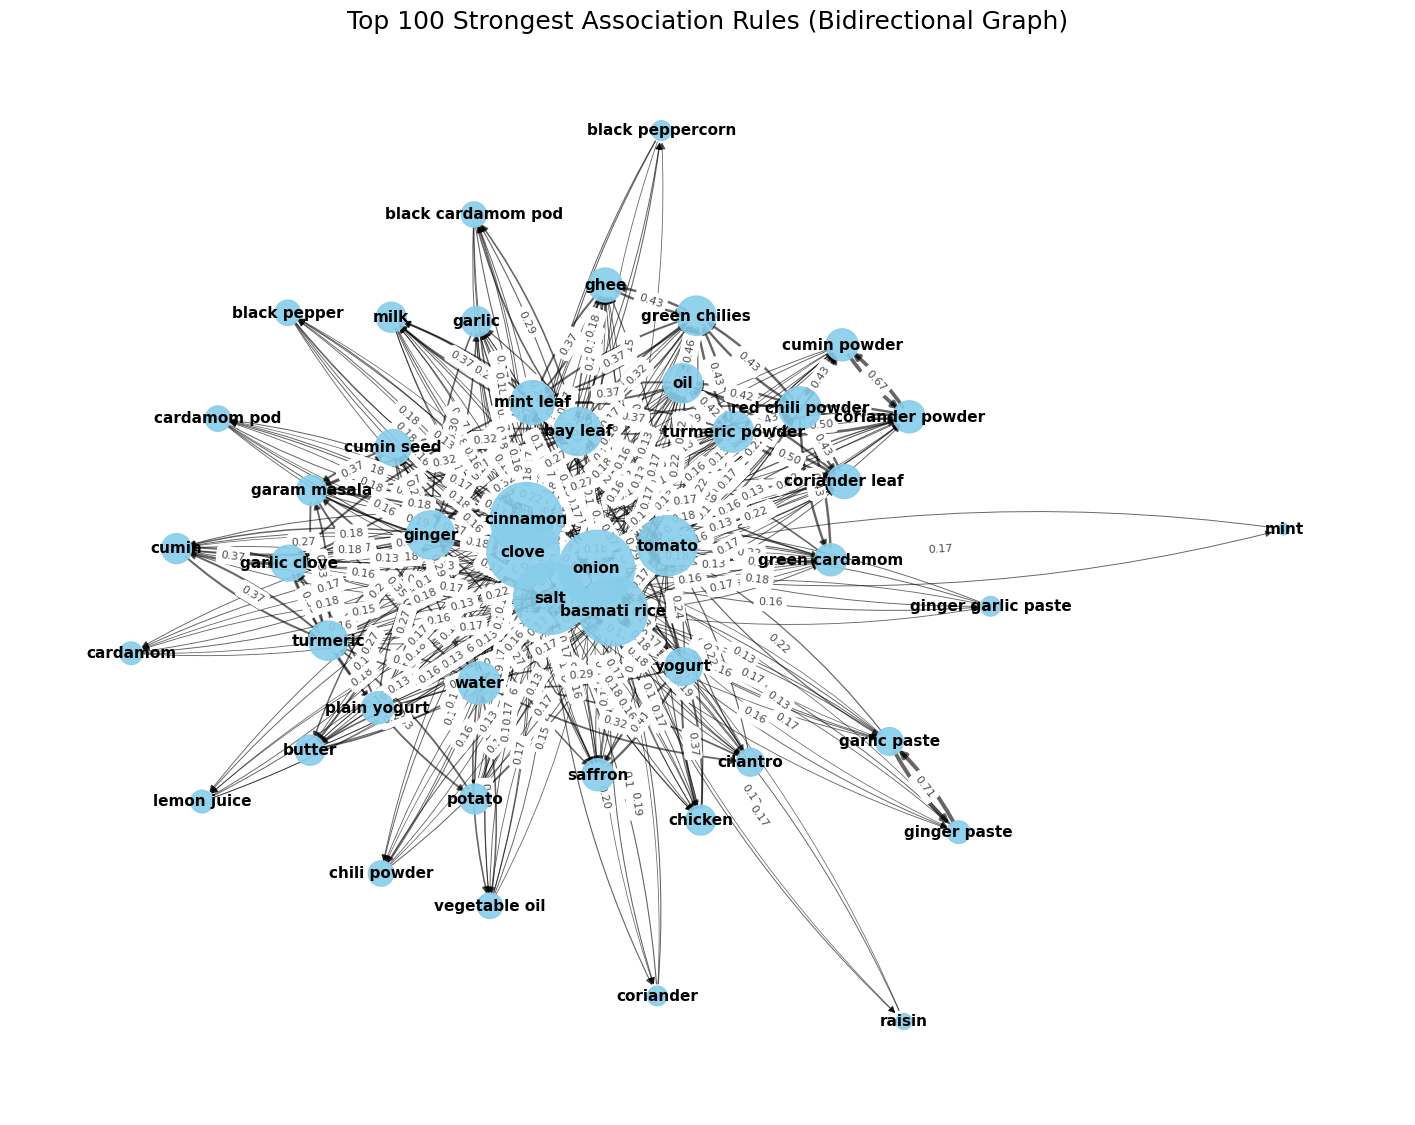

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

top_rules = rules.sort_values(by="confidence", ascending=False)

G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(
                antecedent, consequent,
                weight=row['confidence'],
                support=row['support'],
                lift=row['lift']
            )
            G.add_edge(
                consequent, antecedent,
                weight=row['confidence'],
                support=row['support'],
                lift=row['lift']
            )

plt.figure(figsize=(18, 14))
pos = nx.spring_layout(G, k=0.7, iterations=200)

node_sizes = [3000 * (G.degree(node)/max(dict(G.degree()).values())) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.9)

edge_weights = [d['weight']*4 for (_, _, d) in G.edges(data=True)]
nx.draw_networkx_edges(
    G, pos, width=edge_weights, alpha=0.6, arrows=True, connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, alpha=0.7)

plt.title("Top 100 Strongest Association Rules (Bidirectional Graph)", fontsize=18)
plt.axis("off")
plt.show()

nx.write_graphml(G, "association_rules_biryani.graphml")


In [17]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

categories_df = pd.read_csv("RecipeDB_ingredient_flavor.csv")

query = "Chicken and Spice"
query_parts = [q.strip() for q in query.lower().split("and")]

focus_items = []
for q in query_parts:
    q_cap = q.capitalize()
    if q_cap in categories_df["Dietrx_Category"].unique():
        focus_items.extend(
            categories_df[categories_df["Dietrx_Category"] == q_cap]["ingredient"].str.lower().tolist()
        )
    else:
        focus_items.append(q)

focus_items = list(set(focus_items))
print("Focus items:", focus_items)

filtered_recipes = []
for rec in df["ingredients"].apply(lambda x: [i.lower() for i in x]):
    match = True
    for q in query_parts:
        q_cap = q.capitalize()
        if q_cap in categories_df["Dietrx_Category"].unique():
            category_items = categories_df[categories_df["Dietrx_Category"] == q_cap]["ingredient"].str.lower().tolist()
            if not any(item in rec for item in category_items):
                match = False
                break
        else:
            if q not in rec:
                match = False
                break
    if match:
        filtered_recipes.append(rec)

print(f"Total recipes matching query '{query}': {len(filtered_recipes)}")

# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(filtered_recipes).transform(filtered_recipes)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)
frequent_itemsets['count'] = frequent_itemsets['support'] * len(df_encoded)

# Convert frozenset to list for readability
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: list(x))

def show_itemsets_by_size(size, n=5):
    subset = frequent_itemsets[frequent_itemsets['length'] == size]
    print(f"\nTop {n} frequent itemsets of size {size}:")
    print(subset[['itemsets', 'length', 'support', 'count']].head(n))

for s in range(1, 7):
    show_itemsets_by_size(s, 5)
    
print("\nNumber of frequent itemsets by length:")
summary = frequent_itemsets['length'].value_counts().sort_index()
for length, count in summary.items():
    print(f"Length {length}: {int(count)} itemsets")

# Association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print("\nTop Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence']].head(10))


Focus items: ['montreal seasoning', 'chipotle lime rub seasoning', 'red achiote paste', 'red jalapeno chile thai', 'jalapeno pepper chili guindilla', 'lime cumin vinaigrette', 'jalapeno green chile', 'mccormick grill seasoning', 'red pepper powder', 'bush texas chili magic starter', 'moroccan spice seasoning', 'arabic spice', 'mexican chile powder', 'gingerroot 45g', 'vegetable pepper', 'mulling spice', 'kashmiri chilies', 'onion flake powder', 'hungarian wax chile', 'extra spicy seasoning', 'greek pepper', 'jalapeno chilies', 'cascable chili', 'new mexico chile', 'pizza topping', 'meat pork beef pepper', 'soul food seasoning', 'piri', 'roast chicken seasoning', 'ginger liqueur', 'cuban seasoning', 'italian herb mix spice', 'mexican seasoning mix', 'lowry fajita seasoning mix', 'flat', 'amchoor mango powder', 'pine seed', 'peppercorn red black', 'chi seasoning mix', 'bell seasoning', 'chili heat', 'yellow pepper red', 'el taco seasoning mix', 'hiram walker root', 'mccormick black peppe

c:\Users\dhawal bansal\Desktop\cosylab\venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


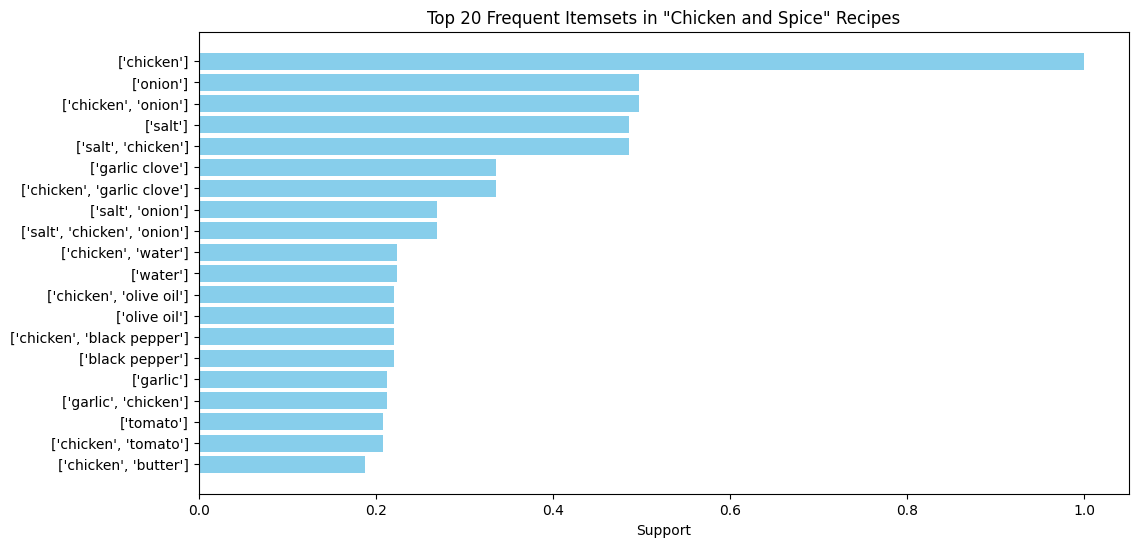

In [18]:

top_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).head(20)

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_itemsets)), top_itemsets['support'], color='skyblue')
plt.yticks(range(len(top_itemsets)), top_itemsets['itemsets'].astype(str))
plt.xlabel('Support')
plt.title('Top 20 Frequent Itemsets in "Chicken and Spice" Recipes')
plt.gca().invert_yaxis()
plt.show()


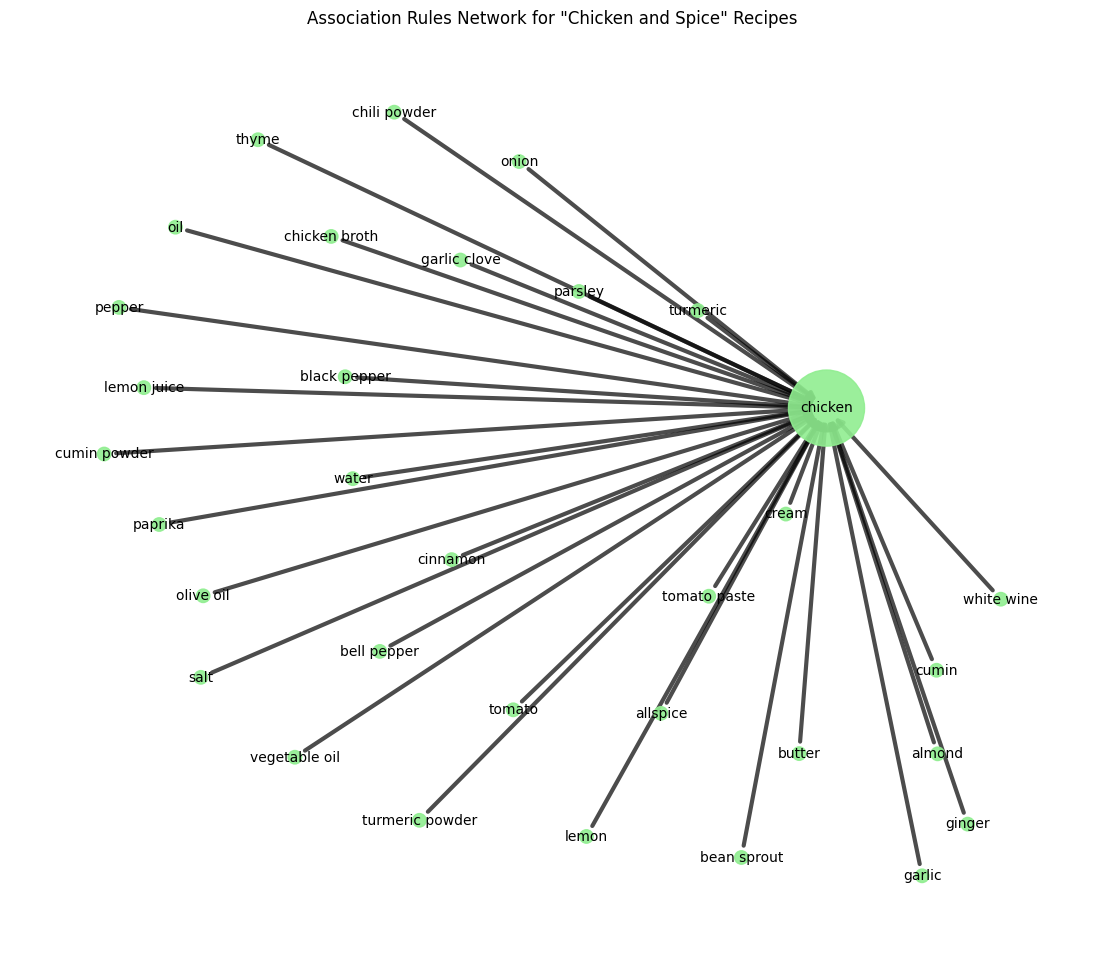

In [19]:
import networkx as nx

top_rules = rules.sort_values(by='confidence', ascending=False).head(50)

G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(
                antecedent, consequent,
                weight=row['confidence'],
                support=row['support'],
                lift=row['lift']
            )

plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, k=0.5, iterations=100)
node_sizes = [3000 * (G.degree(node) / max(dict(G.degree()).values())) for node in G.nodes()]
edge_weights = [d['weight'] * 3 for (_, _, d) in G.edges(data=True)]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightgreen', alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Association Rules Network for "Chicken and Spice" Recipes')
plt.axis('off')
plt.show()

nx.write_graphml(G, "association_rules_chicken.graphml")


Total unique ingredients in chicken recipes: 2398


C:\Users\dhawal bansal\AppData\Local\Temp\ipykernel_13924\2197264296.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chicken_recipes["num_ingredients"] = chicken_recipes["ingredients"].apply(len)


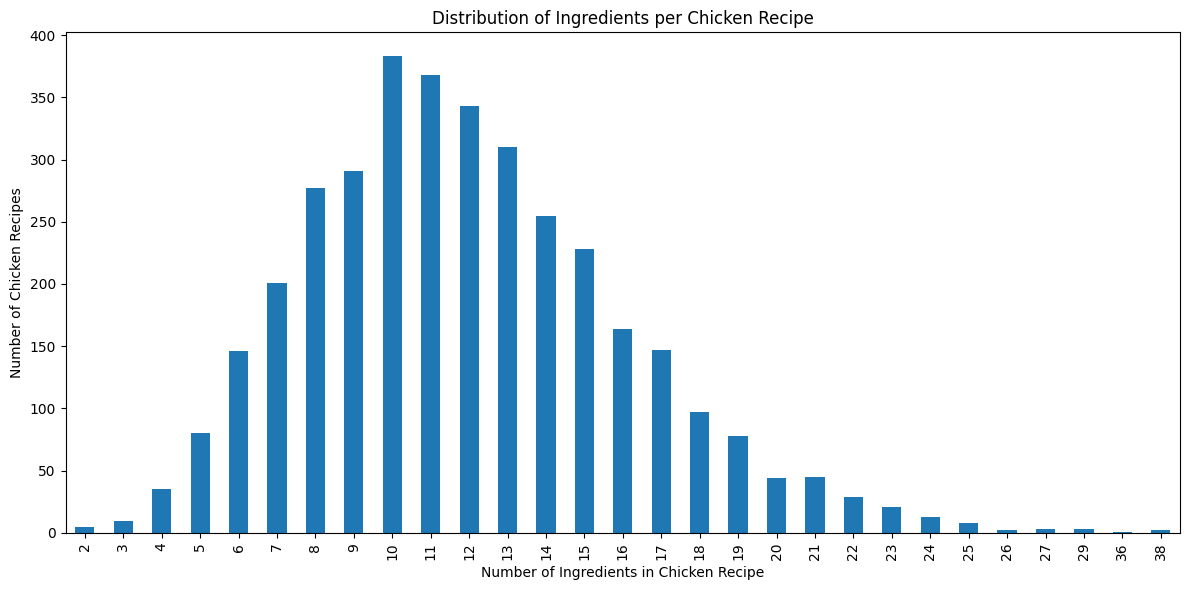

In [20]:
chicken_recipes = df[df["ingredients"].apply(lambda ings: "chicken" in [i.lower() for i in ings])]
# Flatten all ingredients in chicken recipes into a single list (lowercased)
all_chicken_ingredients = [ing.lower() for sublist in chicken_recipes["ingredients"] for ing in sublist]

# Get unique ingredients
unique_chicken_ingredients = set(all_chicken_ingredients)

print(f"Total unique ingredients in chicken recipes: {len(unique_chicken_ingredients)}")

# Number of ingredients per chicken recipe
chicken_recipes["num_ingredients"] = chicken_recipes["ingredients"].apply(len)

# Plot histogram
plt.figure(figsize=(12, 6))
chicken_recipes["num_ingredients"].value_counts().sort_index().plot(kind="bar")

plt.xlabel("Number of Ingredients in Chicken Recipe")
plt.ylabel("Number of Chicken Recipes")
plt.title("Distribution of Ingredients per Chicken Recipe")
plt.tight_layout()
plt.show()


c:\Users\dhawal bansal\Desktop\cosylab\venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


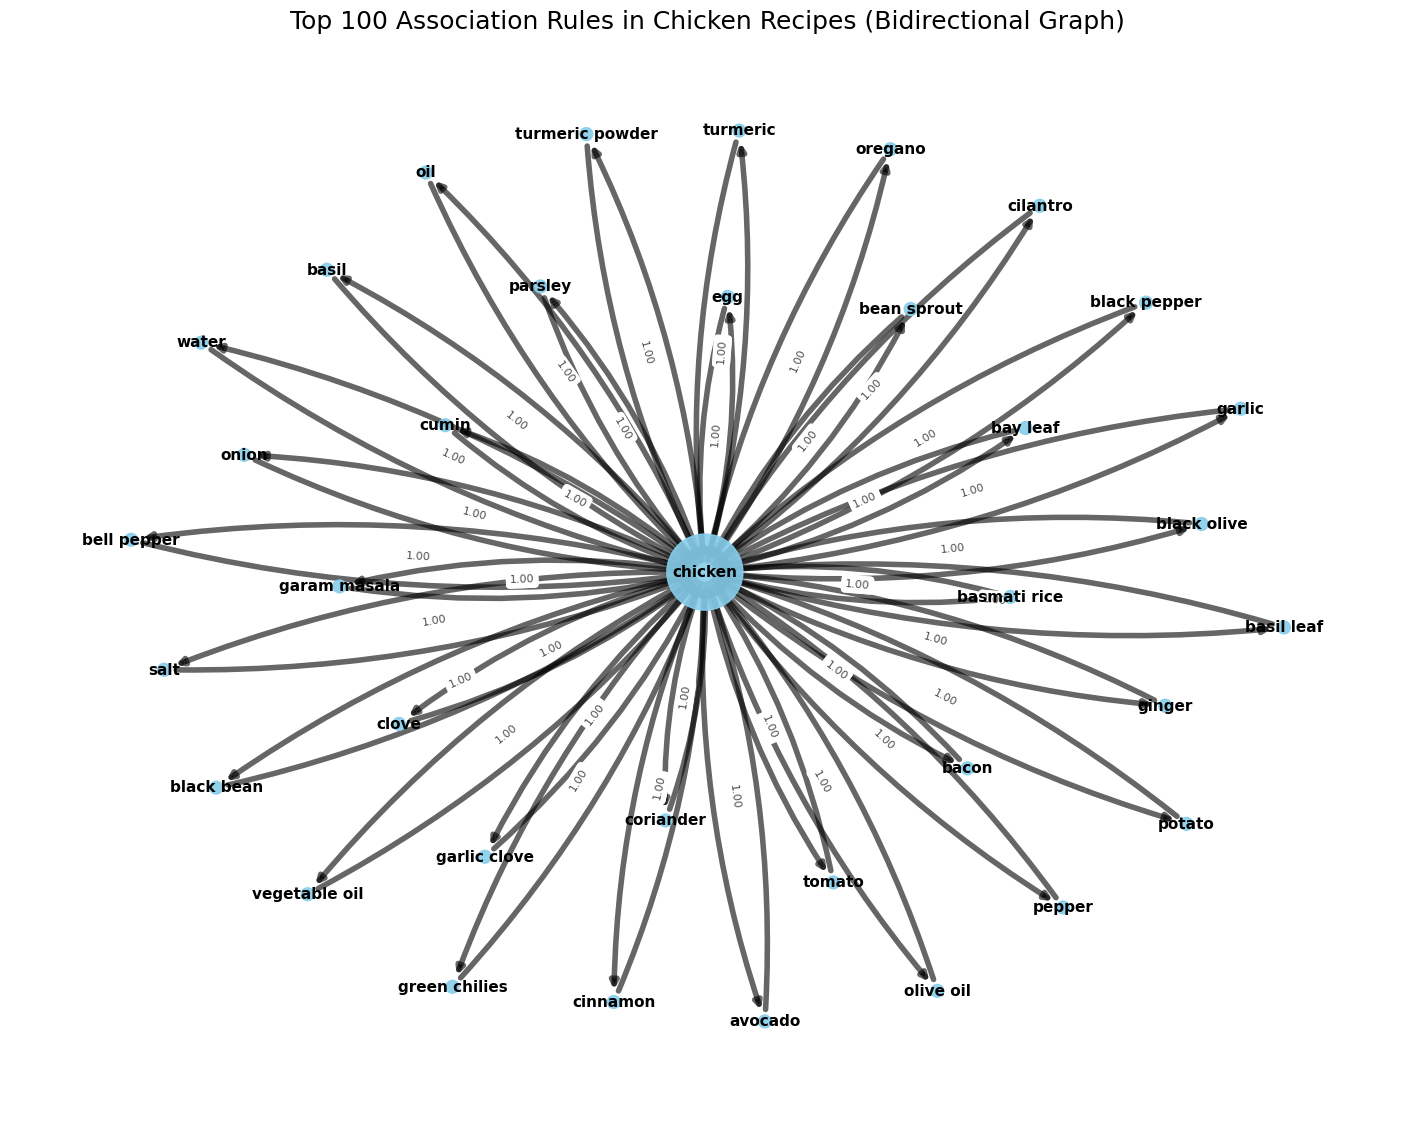

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

chicken_ingredient_lists = chicken_recipes["ingredients"].apply(lambda ings: [i.lower() for i in ings]).tolist()

te = TransactionEncoder()
te_ary = te.fit(chicken_ingredient_lists).transform(chicken_ingredient_lists)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(len)
frequent_itemsets['count'] = frequent_itemsets['support'] * len(df_encoded)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

top_rules = rules.sort_values(by="confidence", ascending=False).head(100)

G = nx.DiGraph()
for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(
                antecedent, consequent,
                weight=row['confidence'],
                support=row['support'],
                lift=row['lift']
            )
            G.add_edge(
                consequent, antecedent,
                weight=row['confidence'],
                support=row['support'],
                lift=row['lift']
            )

# Plot the graph
plt.figure(figsize=(18, 14))
pos = nx.spring_layout(G, k=0.7, iterations=200)

node_sizes = [3000 * (G.degree(node)/max(dict(G.degree()).values())) for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.9)

edge_weights = [d['weight'] * 4 for (_, _, d) in G.edges(data=True)]
nx.draw_networkx_edges(
    G, pos, width=edge_weights, alpha=0.6, arrows=True, connectionstyle="arc3,rad=0.1"
)

nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, alpha=0.7)

plt.title("Top 100 Association Rules in Chicken Recipes (Bidirectional Graph)", fontsize=18)
plt.axis("off")
plt.show()

nx.write_graphml(G, "association_rules_chicken_top100.graphml")
